<a href="https://colab.research.google.com/github/kyunghyuncho/ammi-2019-nlp/blob/master/01-day-LM/ngram_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

## Goal: compute a probabilty distribution over all possible sentences:


## $$p(W) = p(w_1, w_2, ..., w_T)$$

## This unsupervised learning problem can be framed as a sequence of supervised learning problems:

## $$p(W) = p(w_1) * p(w_2|w_1) * ... * p(w_T|w_1, ..., w_{T-1})$$

## If we have N sentences, each of them with T words / tokens, then we want to max:

## $$log p(W) = \sum_{n = 1}^N \sum_{i=1}^{T} log p(w_i | w_{<i})$$




# N-gram language model

## Goal: estimate the n-gram probabilities using counts of sequences of n consecutive words

## Given a sequence of words $w$, we want to compute

##  $$P(w_i|w_{i−1}, w_{i−2}, …, w_{i−n+1})$$

## Where $w_i$ is the i-th word of the sequence.

## $$P(w_i|w_{i−n+1}, ..., w_{i−2}, w_{i−1}) = \frac{p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w_i)}{\sum_{w \in V} p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w)}$$

## Key Idea: We can estimate the probabilities using counts of n-grams in our dataset 


# Let's see this in Practice

### Install if needed

TODO: should we install as needed and import as needed or all at once?

In [1]:
# # run if you dont have it installed
# !pip install more_itertools
# !pip install spacy# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager\
# !python -m spacy download en_core_web_sm

### Imports

In [2]:
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

In [3]:
torch.manual_seed(1)


## Data Processing

### Load Data From .txt Files

In [4]:
# Train Data
train_data = open('../data/amazon_reviews_sports_train.txt').readlines()

In [5]:
# Inspect Train Data        
len(train_data), type(train_data), train_data[0], type(train_data[0]), len(train_data[0])

(237069,
 list,
 "['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', ',', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy']\n",
 str,
 227)

In [6]:
# Validation Data
valid_data = open('../data/amazon_reviews_sports_valid.txt').readlines()

In [7]:
# Inspect Valid Data
len(valid_data), type(valid_data), valid_data[0], type(valid_data[0]), len(valid_data[0])

(29635,
 list,
 "['great', 'sling', 'bag', '.', 'i', 'used', 'it', 'for', 'a', 'trip', 'to', 'disney', 'and', 'this', 'bag', 'worked', 'very', 'well', '.', 'it', 'has', 'enough', 'pockets', 'to', 'carry', 'all', 'the', 'essentials', 'needed', 'for', 'a', 'vacation', 'to', 'disney', 'in', 'june', '.', 'i', 'was', 'able', 'to', 'carry', 'so', 'mush', 'stuff', 'in', 'this', 'bag', 'my', 'wife', 'did', 'not', 'have', 'to', 'carry', 'a', 'back', 'pack', '.', 'i', 'gonna', 'to', 'carry', 'this', 'bag', 'for', 'all', 'my', 'trips', 'from', 'now', 'on', 'and', 'it', 'worked', 'well', 'through', 'all', 'the', 'airport', 'security', 'checks', '.', 'i', 'highly', 'recommend', 'this', 'bag', '.']\n",
 str,
 677)

In [8]:
# Test Data
test_data = open('../data/amazon_reviews_sports_test.txt').readlines()

In [9]:
# Inspect Test Data
len(test_data), type(test_data), test_data[0], type(test_data[0]), len(test_data[0])

(29633,
 list,
 '[\'this\', \'is\', \'the\', \'most\', \'affordable\', \'/\', \'highest\', \'quality\', \'made\', \'in\', \'the\', \'usa\', \'knife\', \'i\', \'have\', \'found\', \'.\', \'the\', \'knife\', \'is\', \'very\', \'lightweight\', \',\', \'lighter\', \'than\', \'my\', \'kershaw\', \'blur\', \'and\', \'its\', \'a\', \'bit\', \'thinner\', \'too\', \'.\', \'typically\', \'really\', \'lightweight\', \'knives\', \'have\', \'frn\', \'handles\', \'like\', \'the\', \'endura\', \'4\', \'or\', \'the\', \'griptillian\', \'and\', \'that\', "\'", \'s\', \'fine\', \'but\', \'that\', \'stuff\', \'does\', \'flex\', \'if\', \'u\', \'squeeze\', \'hard\', \'enough\', \'.\', \'the\', \'aluminum\', \'handles\', \'in\', \'the\', \'knockout\', \'feel\', \'really\', \'strong\', \'and\', \'have\', \'no\', \'give\', \'to\', \'them\', \'and\', \'i\', \'prefer\', \'the\', \'feel\', \'of\', \'metal\', \'over\', \'plastic\', \'any\', \'day\', \'.\', \'there\', \'was\', \'a\', \'little\', \'rattle\', \'if\

### Process the Data

In [10]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')               
punctuations = string.punctuation   
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)] #and (token.is_stop is False)]

def tokenize_dataset(dataset):
   # tokenize each sentence -- each tokenized sentence will be an element in token_dataset
    token_dataset = []
    # tokenize all words -- each token will be an item in all_tokens (in the order given by the list of sentences)
    all_tokens = []     # all the tokens -- 

    for sample in tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case_remove_punc(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
        
    return token_dataset, all_tokens

In [11]:
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
TAG_RE

re.compile(r'<[^>]+>', re.UNICODE)

In [13]:
train_data[:2]

["['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', ',', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy']\n",
 '[\'i\', \'had\', \'a\', \'factory\', \'glock\', \'tool\', \'that\', \'i\', \'was\', \'using\', \'for\', \'my\', \'glock\', \'26\', \',\', \'27\', \',\', \'and\', \'17\', \'.\', \'i\', "\'", \'ve\', \'since\', \'lost\', \'it\', \'and\', \'had\', \'needed\', \'another\', \'.\', \'since\', \'i\', "\'", \'ve\', \'used\', \'ghost\', \'products\', \'prior\', \',\', \'and\', \'know\', \'that\', \'they\', \'are\', \'reliable\', \',\', \'i\', \'had\', \'decided\', \'to\', \'order\', \'this\', \'one\', \'.\', \'sure\', \'enough\', \',\', \'this\', \'is\', \'just\', \'as\', \'good\', \'as\', \'a\', \'factory\', \'tool\', \'.\']\n']

In [64]:
# TODO: for now only work with small subset of the data -- switch to all data later
train_data = train_data[:8000]
test_data = test_data[:1000]
valid_data = valid_data[:1000]

In [65]:
train_data[0], len(train_data)

("['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', ',', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy']\n",
 800)

In [66]:
# Tokenize the Datasets
# TODO: this takes a really long time !! why?
train_data_tokenized, all_tokens_train = tokenize_dataset(train_data)
test_data_tokenized, all_tokens_test = tokenize_dataset(test_data)
valid_data_tokenized, all_tokens_valid = tokenize_dataset(valid_data)


800it [00:00, 881.28it/s]
100it [00:00, 1409.27it/s]
100it [00:00, 1125.89it/s]


Let's look at the tokenized data!

In [67]:
# Number of Tokenized Sentences == Number of All Sentences in the Dataset
# Compare the Tokenized Sentences with the Original Ones
len(train_data_tokenized), train_data_tokenized[:2], train_data[:2]

(800,
 [['this',
   'came',
   'in',
   'on',
   'time',
   'and',
   'i',
   'am',
   'veru',
   'happy',
   'with',
   'it',
   'i',
   'haved',
   'used',
   'it',
   'already',
   'and',
   'it',
   'makes',
   'taking',
   'out',
   'the',
   'pins',
   'in',
   'my',
   'glock',
   '32',
   'very',
   'easy',
   '\n'],
  ['i',
   'had',
   'a',
   'factory',
   'glock',
   'tool',
   'that',
   'i',
   'was',
   'using',
   'for',
   'my',
   'glock',
   '26',
   '27',
   'and',
   '17',
   'i',
   've',
   'since',
   'lost',
   'it',
   'and',
   'had',
   'needed',
   'another',
   'since',
   'i',
   've',
   'used',
   'ghost',
   'products',
   'prior',
   'and',
   'know',
   'that',
   'they',
   'are',
   'reliable',
   'i',
   'had',
   'decided',
   'to',
   'order',
   'this',
   'one',
   'sure',
   'enough',
   'this',
   'is',
   'just',
   'as',
   'good',
   'as',
   'a',
   'factory',
   'tool',
   '\n']],
 ["['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am'

In [68]:
# Number of All Tokens
len(all_tokens_train), all_tokens_train[:2]

(78453, ['this', 'came'])

#### Build the Vocabulary 


In [69]:
# TODO: do we use both train and valid and not test for this??
voc = list(set(all_tokens_train + all_tokens_valid))
print('Word vocabulary size: {} words'.format(len(voc)))             

Word vocabulary size: 6281 words


### CORPUS ANALYSIS (Train + Valid Data)

#### Number of Tokens in the Corpus Data


In [70]:
print("Number of All Tokens ", len(all_tokens_train) + len(all_tokens_valid))

Number of All Tokens  85962


In [71]:
print("Number of All UNIQUE Tokens ", len(voc))

Number of All UNIQUE Tokens  6281


#### Number of Sentences in the Train Data


In [72]:
print("Number of Sentences ", len(train_data_tokenized), len(valid_data_tokenized))

Number of Sentences  800 100


#### Count how often each sentence length occurs. Visualize this! 

#### Average sentence length

## N-grams

#### Generate a list of words and their corresponding frequencies. Which are the 10 most frequent words?



### Function for padding the sentences with special markers sentence beginning and end, i.e. $<bos>$ and $<eos>$

In [73]:
def pad_sentences(input_list, n):
    result_list = []
    for l in input_list:
        padded = ["<bos>" for i in range((n - 1))] + l +["<eos>" for i in range((n - 1))]
        result_list.append(padded)
    return result_list

In [74]:
NGRAM = 2  # change this to make different N grams for each token

train_data_padded = pad_sentences(train_data_tokenized, NGRAM)
test_data_padded = pad_sentences(test_data_tokenized, NGRAM)
valid_data_padded = pad_sentences(valid_data_tokenized, NGRAM)


Let's check our padding!

In [75]:
train_data_padded[0]

['<bos>',
 'this',
 'came',
 'in',
 'on',
 'time',
 'and',
 'i',
 'am',
 'veru',
 'happy',
 'with',
 'it',
 'i',
 'haved',
 'used',
 'it',
 'already',
 'and',
 'it',
 'makes',
 'taking',
 'out',
 'the',
 'pins',
 'in',
 'my',
 'glock',
 '32',
 'very',
 'easy',
 '\n',
 '<eos>']

### Function for finding all N-grams

In [76]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list

#### Convert the dataset to its corresponding n-gram version

In [77]:
NGRAM = 2  # change this to make different N grams for each token

# now make train and valid dicts
train_data_ngram = find_ngrams(train_data_padded, NGRAM)
valid_data_ngram = find_ngrams(valid_data_padded, NGRAM)
test_data_ngram = find_ngrams(test_data_padded, NGRAM)

Let's check our n-grams!

In [78]:
train_data_ngram[0]

[('<bos>', 'this'),
 ('this', 'came'),
 ('came', 'in'),
 ('in', 'on'),
 ('on', 'time'),
 ('time', 'and'),
 ('and', 'i'),
 ('i', 'am'),
 ('am', 'veru'),
 ('veru', 'happy'),
 ('happy', 'with'),
 ('with', 'it'),
 ('it', 'i'),
 ('i', 'haved'),
 ('haved', 'used'),
 ('used', 'it'),
 ('it', 'already'),
 ('already', 'and'),
 ('and', 'it'),
 ('it', 'makes'),
 ('makes', 'taking'),
 ('taking', 'out'),
 ('out', 'the'),
 ('the', 'pins'),
 ('pins', 'in'),
 ('in', 'my'),
 ('my', 'glock'),
 ('glock', '32'),
 ('32', 'very'),
 ('very', 'easy'),
 ('easy', '\n'),
 ('\n', '<eos>')]

#### Generate a complete list of trigrams occurring in the corpus. Which are the 10 most frequent trigrams?



#### Determine count statistics on the trigram frequencies, i.e. compute so-called count-counts (how many trigrams occur once, twice, : : :). Plot their distribution.

### Create N-gram Vocabulary with Corresponding Counts

In [79]:
max_vocab_size = 100000

all_train_tokens = list(mit.flatten(train_data_ngram + valid_data_ngram))
counted_tokens = Counter(all_train_tokens)

vocab, count = zip(*counted_tokens.most_common(max_vocab_size))


In [80]:
# Let's look at some numbers!
len(all_train_tokens), len(vocab), len(count)

(86862, 41952, 41952)

In [81]:
vocab[:2], count[:2]

((('\n', '<eos>'), ('of', 'the')), (900, 332))

### Create N-gram Dictionary

In [82]:
# save index 1 for unk, 0 for pad, 1 for bos, 2 for eos
PAD_IDX = 0
UNK_IDX = 1
BOS_IDX = 2
EOS_IDX = 3

id2token = list(vocab)
token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

token2id['<pad>'] = PAD_IDX 
token2id['<unk>'] = UNK_IDX
token2id['<bos>'] = BOS_IDX 
token2id['<eos>'] = EOS_IDX

In [83]:
len(id2token), len(token2id)

(41956, 41956)

Lets check the dictionary by loading random token from it!


In [84]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 30366 ; token ('little', 'duller')
Token ('little', 'duller'); token id 30366


#### Generate a list of trigrams in the corpus using only the words in the vocabulary. 

#### Generate count statistics of the trigram frequencies for this modified corpus as well. What do you notice in comparison to the previous exercise?

#### Determine the out-of-vocabulary (OOV) rate, i.e. the percentage of running words in the corpus which are not covered by the vocabulary.

### Functions for Converting from Token to ID and back

In [85]:
def _text2id(doc):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec):
    return [id2token[i] for i in vec]
    

In [86]:
train_data_id = []
for d in train_data_ngram:
    train_data_id.append(_text2id(d))
    
valid_data_id = []
for d in valid_data_ngram:
    valid_data_id.append(_text2id(d))
    
train_data_id_merged = []
for d in train_data_id:
    train_data_id_merged.append((d, 0))

valid_data_id_merged = []
for d in valid_data_id:
    valid_data_id_merged.append((d, 0))


In [87]:
len(train_data_id), len(train_data_id_merged), train_data_id_merged[0]

(800,
 800,
 ([24,
   9866,
   2508,
   3418,
   3419,
   370,
   19,
   52,
   9867,
   9868,
   399,
   136,
   139,
   9869,
   9870,
   435,
   5240,
   9871,
   21,
   887,
   9872,
   9873,
   324,
   9874,
   9875,
   31,
   1316,
   9876,
   9877,
   702,
   9878,
   4],
  0))

In [88]:
# let's look at what we created
train_data_id[0][0], train_data_ngram[0][0], train_data_id_merged[0][0], len(train_data_id_merged), len(train_data_id)

(24,
 ('<bos>', 'this'),
 [24,
  9866,
  2508,
  3418,
  3419,
  370,
  19,
  52,
  9867,
  9868,
  399,
  136,
  139,
  9869,
  9870,
  435,
  5240,
  9871,
  21,
  887,
  9872,
  9873,
  324,
  9874,
  9875,
  31,
  1316,
  9876,
  9877,
  702,
  9878,
  4],
 800,
 800)

In Part 1 you generated a trigram frequency list for a given vocabulary.
Determine the list of bigram frequencies from it by summing over the first word position:
N(v;w) = N(; v;w) =
X
u
N(u; v;w)
Analogously, recompute the frequencies of unigrams.
Now, extract bigrams/unigrams directly from the corpus using your implementation from part 1
and compare it to the recomputed versions. What do you notice? How could you x this problem
without changing the recomputation method?

### Function for Getting N-gram counts for already tokenized data

In [89]:
def ngram_counts(data, n):
    print("data item ", data[0], "\n")
    data_pad = pad_sentences(data, n)
    print("padded item ", data_pad[0], "\n")
    ngram_data = find_ngrams(data_pad, n)
    print("ngram item ", ngram_data[0], "\n")
    all_train_tokens = list(mit.flatten(ngram_data))
    counted_tokens = Counter(all_train_tokens)
    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    print("vocab item ", vocab[0], "\n")
    print("count item ", count[0], "\n")
    return vocab, count

### Function for Getting N-gram Dict

In [90]:
def ngram_dict(data, n):
    data_pad = pad_sentences(data, n)
    ngram_data = find_ngrams(data_pad, n)
    
    all_train_tokens = list(mit.flatten(ngram_data))
    counted_tokens = Counter(all_train_tokens)
    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    
    # save index 1 for unk, 0 for pad, 1 for bos, 2 for eos
    PAD_IDX = 0
    UNK_IDX = 1
    BOS_IDX = 2
    EOS_IDX = 3

    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<bos>'] = BOS_IDX 
    token2id['<eos>'] = EOS_IDX
    
    data_ids = []
    for d in ngram_data:
        data_ids.extend(_text2id(d))

    return id2token, token2id, data_ids, vocab, count

### Unigram Counts

In [91]:
train_data_tokenized[0]

['this',
 'came',
 'in',
 'on',
 'time',
 'and',
 'i',
 'am',
 'veru',
 'happy',
 'with',
 'it',
 'i',
 'haved',
 'used',
 'it',
 'already',
 'and',
 'it',
 'makes',
 'taking',
 'out',
 'the',
 'pins',
 'in',
 'my',
 'glock',
 '32',
 'very',
 'easy',
 '\n']

In [92]:
vocab_unigrams, count_unigrams = ngram_counts(train_data_tokenized, 1)
vocab_unigrams[:2], count_unigrams[:2]

data item  ['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n'] 

padded item  ['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n'] 

ngram item  [('this',), ('came',), ('in',), ('on',), ('time',), ('and',), ('i',), ('am',), ('veru',), ('happy',), ('with',), ('it',), ('i',), ('haved',), ('used',), ('it',), ('already',), ('and',), ('it',), ('makes',), ('taking',), ('out',), ('the',), ('pins',), ('in',), ('my',), ('glock',), ('32',), ('very',), ('easy',), ('\n',)] 

vocab item  ('the',) 

count item  3752 



((('the',), ('i',)), (3752, 2508))

### Bigram Counts

In [93]:
vocab_bigrams, count_bigrams = ngram_counts(train_data_tokenized, 2)
vocab_bigrams[:2], count_bigrams[:2]

data item  ['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n'] 

padded item  ['<bos>', 'this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n', '<eos>'] 

ngram item  [('<bos>', 'this'), ('this', 'came'), ('came', 'in'), ('in', 'on'), ('on', 'time'), ('time', 'and'), ('and', 'i'), ('i', 'am'), ('am', 'veru'), ('veru', 'happy'), ('happy', 'with'), ('with', 'it'), ('it', 'i'), ('i', 'haved'), ('haved', 'used'), ('used', 'it'), ('it', 'already'), ('already', 'and'), ('and', 'it'), ('it', 'makes'), ('makes', 'taking'), ('taking', 'out'), ('out', 'the'), ('the', 'pins'), ('pins', 'in'), ('in', 'my'), ('my', 'glock'), ('glock', '32'), ('32', 'very'), 

((('\n', '<eos>'), ('of', 'the')), (800, 299))

### Trigram Counts

In [94]:
vocab_trigrams, count_trigrams = ngram_counts(train_data_tokenized, 3)
vocab_trigrams[:2], count_trigrams[:2]

data item  ['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n'] 

padded item  ['<bos>', '<bos>', 'this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy', '\n', '<eos>', '<eos>'] 

ngram item  [('<bos>', '<bos>', 'this'), ('<bos>', 'this', 'came'), ('this', 'came', 'in'), ('came', 'in', 'on'), ('in', 'on', 'time'), ('on', 'time', 'and'), ('time', 'and', 'i'), ('and', 'i', 'am'), ('i', 'am', 'veru'), ('am', 'veru', 'happy'), ('veru', 'happy', 'with'), ('happy', 'with', 'it'), ('with', 'it', 'i'), ('it', 'i', 'haved'), ('i', 'haved', 'used'), ('haved', 'used', 'it'), ('used', 'it', 'already'), ('it', 'already', 'and'), ('already', 'and', 'it'), ('and', 'i

((('\n', '<eos>', '<eos>'), ('<bos>', '<bos>', 'i')), (800, 277))

#### Determine the list of bigram frequencies from it by summing over the first word position:

#### $ N(u, v, w) = \sum_u N(\cdot, v, w) $

#### Do the same for the unigrams. Do we get the same numbers as before?

## N-gram Probabilities

## $$P(w|w_{−n}, ..., w_{−2}, w_{−1}) \approx \frac{c(w_{−n}, ..., w_{−2}, w_{−1}, w)}{\sum_{w \in V} c(w_{−n}, ..., w_{−2}, w_{−1}, w)}$$


## Bigram Probabilities

## $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{\sum_{w_i} c(w_{i-1}, w_i)} $$


## Bigram LM
##  $$p(s) = \prod_{i = 1} ^ {N + 1} p(w_i | w_{i-1})$$

### Function for computing the probability of an n-gram

In [95]:
def get_count_ngram(data, token, n):
    id2token, token2id, data_ids, vocab, count = ngram_dict(data, n)
    if token in token2id:
        return np.sum([i == token_id for i in data])
    else:
        return 0

In [96]:
def get_prob_ngram(data, token, n):
    count = get_count_ngram(data, token, n)
    all_counts = 0
    for t in vocab:
        all_counts += get_count_ngram(data, t, n)
    if all_counts > 0:
        return count / all_counts
    else:
        return 0

### Function for computing the probability of a sentence

In [97]:
def get_prob_sentence(vocab, count, n):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-97-26cfecd6b523>, line 2)

### Example
### Bigram LM: $$ p(i \; love \; this \; light) = p(i|\cdot) \; p(love|i)\;  p(this|love)\;  p(light|this) \\
\approx \frac{c(i, \cdot)}{\sum_w c(\cdot, \; w)} \; \frac{c(love, i)}{\sum_wc(i, \; w)}\;  \frac{c(this, love)}{\sum_wc(love, \;w)}\;  \frac{c(light, this)}{\sum_wc(this, \;w)}$$ 

### Trigram LM: $$ p(i \; love \; this  \;light) = p(i|\cdot, \cdot) \; p(love|\cdot, i) \; p(this|i, love)\;  p(light|love, this)$$ 



### Another Example -- where this approach usually fails

### Bigram LM: $$ p(john \; went \; to \; the \; moon) = p(john|\cdot) p(went|john) p(to|went) p(the|to) p(moon|the)$$ 

### Trigram LM: $$ pp(john \; went \; to \; the \; moon = p(john|\cdot, \cdot) p(went|\cdot, john) p(to|john, went) p(the|went, to) p(moon|to, the)$$ 



## Smoothing -- which ones to show? comparisons?

### Why do we need smoothing for n-gram language modeling?

## Add-One Smoothing

## Additive Smoothing

## Smoothing: Linear Interpolation with Absolute Discounting

## Bigram Probabilities

### $$p_{bi} = max \large{ \frac{N(v, w) - b_{bi}}{N(v), 0}  + b_{bi} \frac{V - N_0(v, \cdot)}{N(v)} p_{uni(w)} \large}$$

### $$p_{uni} = max \large{ \frac{N(w) - b_{uni}}{N, 0}  + b_{uni} \frac{V - N_0(\cdot)}{N} \frac{1}{V}}$$

### $$b_{bi} = \frac{N_1(\cdot, \cdot)}{N_1(\cdot, \cdot) + 2*N_2(\cdot, \cdot)}$$

### $$b_{uni} = \frac{N_1(\cdot)}{N_1(\cdot) + 2*N_2(\cdot)}$$


### $$N_r(\cdot) = \sum_{w: N(w) = r} 1$$

### $$N_r(\cdot, \cdot) = \sum_{v, w: N(v, w) = r} 1$$

### $$N_r(v, \cdot) = \sum_{w: N(v, w) = r} 1$$

### V is the number of words in the vocabulary

### $N_r(\cdot, \cdot)$ and $N_r(\cdot)$  are the count-counts for bigrams and unigrams respectively $


In [98]:
# TODO: Let's compute the bigram frequencies / probabilities



### Let's check that the probabilities sum up to one
### $$\sum_w p_{bi}(w|v) = \sum_w p_{uni}(w) = 1$$



In [99]:
# TODO: compute the sums



#### Let's look at some examples and see if they make sense

### Perplexity

### $PP = exp(-\frac{LL}{\sum_k(N_k + 1)})$

### $LL = \sum_{k=1}^{K} \sum_{n=1}^{N_k + 1} log p_{bi}(w_{k,n} | w_{k,n-1})$

### Sentece Probability

### Sentence Generation

# Neural Language Modeling

## Make a PyTorch Dataset out of our set of dicts

In [100]:
class ImdbDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            self.data_tensors.append((torch.LongTensor(i[:self.max_len]), torch.LongTensor([t])))
            #TODO: fix error regarding to(device)
#             self.data_tensors.append((torch.LongTensor(i[:self.max_len]).to(device), torch.LongTensor([t]).to(device)))
              
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [101]:
train_dataset = ImdbDataset(train_data_id_merged, max_inp_length=None, device='cuda')
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = ImdbDataset(valid_data_id_merged, max_inp_length=None, device='cuda')
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

## Model

In [103]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=512, reduce='sum', nlayers=2, act='ReLU', nclasses=2, dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.nclasses = nclasses
        self.act = getattr(nn, act)
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.act())
        self.layers.append(nn.Dropout(p=dropout))
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.act())
            self.layers.append(nn.Dropout(p=dropout))
        self.layers.append(nn.Linear(self.hidden_size, 1))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(id2token), emb_dim=30, hidden_size=2048, act='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

BagOfNGrams(
  (embedding): EmbeddingBag(41956, 30, mode=mean)
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=2048, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0)
    (3): Linear(in_features=2048, out_features=1, bias=True)
  )
)

## Loss and Optimizer


In [104]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Testing 

In [105]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## Training

In [106]:
# TODO fix cuda issue!!! 

train_losses = []

for epoch in range(num_epochs):
    for i, (data, labels) in tqdm(enumerate(train_loader)): 
        data.cpu()
        labels.cpu()
        model.cpu()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        outputs.cuda()
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))

2it [00:00,  3.18it/s]
2it [00:00,  5.23it/s]
0it [00:00, ?it/s]

Epoch: [2/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.35it/s]
0it [00:00, ?it/s]

Epoch: [3/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.15it/s]
0it [00:00, ?it/s]

Epoch: [4/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.59it/s]
0it [00:00, ?it/s]

Epoch: [5/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.55it/s]
0it [00:00, ?it/s]

Epoch: [6/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  2.82it/s]
0it [00:00, ?it/s]

Epoch: [7/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  4.70it/s]
0it [00:00, ?it/s]

Epoch: [8/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.54it/s]
0it [00:00, ?it/s]

Epoch: [9/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.80it/s]
0it [00:00, ?it/s]

Epoch: [10/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  5.14it/s]
0it [00:00, ?it/s]

Epoch: [11/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  5.01it/s]
0it [00:00, ?it/s]

Epoch: [12/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.92it/s]
0it [00:00, ?it/s]

Epoch: [13/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  4.47it/s]
0it [00:00, ?it/s]

Epoch: [14/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.51it/s]
0it [00:00, ?it/s]

Epoch: [15/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.62it/s]
0it [00:00, ?it/s]

Epoch: [16/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.65it/s]
0it [00:00, ?it/s]

Epoch: [17/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  2.98it/s]
0it [00:00, ?it/s]

Epoch: [18/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.31it/s]
0it [00:00, ?it/s]

Epoch: [19/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


2it [00:00,  3.85it/s]

Epoch: [20/20], Step: [2/2], Train loss: 0.0, Validation Acc: 100.0


#### Visualize the Loss 

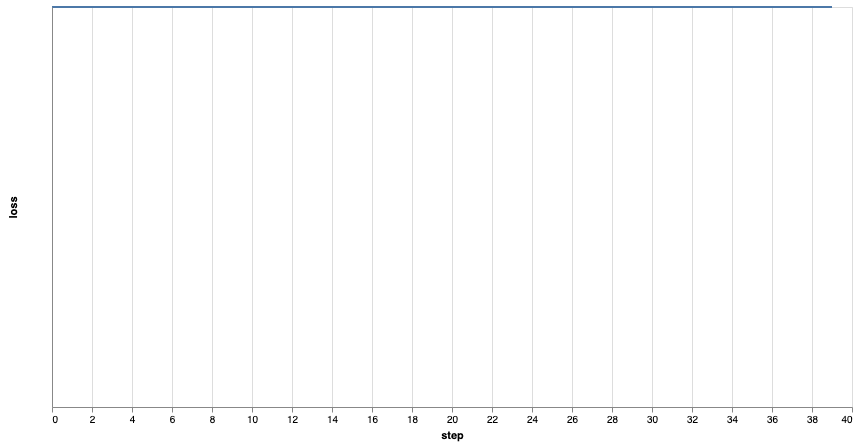

In [107]:
#!pip install altair
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

## Analysis & Examples

## Compare N-gram LM to Neural LM

## Using FastText

## Using KenLM

In [16]:
out = vocab.FastText(language='en')

.vector_cache/wiki.en.vec:  19%|█▉        | 1.25G/6.60G [11:49<50:35, 1.76MB/s]


KeyboardInterrupt: 

In [ ]:
text_field.build_vocab(dataset, max_size=30000, vectors=out)

In [ ]:
# making a batch iterator
train_loader = data.BucketIterator(dataset=dataset, batch_size=4, sort_key=lambda x: len(x.reviewText), device=torch.device('cpu'), sort_within_batch=True, repeat=False)

In [ ]:
batch = next(iter(train_loader))
print(batch)

In [ ]:
def _vec2txt(vec):
    return [text_field.vocab.itos[t] for t in vec]

In [ ]:
print(batch.reviewText[0][0])
print(_vec2txt(batch.reviewText[0][0]))